<a href="https://colab.research.google.com/github/mouadnechchad/Face-Mask-Detection-/blob/main/YOLOv8_Face_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load dataset from Kaggle

In [ ]:
pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'mouadnechchad'
os.environ['KAGGLE_KEY'] = 'xxxxxxxxxxxxxxxxxxxx'

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 99% 395M/398M [00:12<00:00, 26.4MB/s]
100% 398M/398M [00:12<00:00, 34.4MB/s]


## Unzip the dataset

In [ ]:
!unzip face-mask-detection.zip && rm face-mask-detection.zip

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

## Data Split

In [ ]:
import os
import random
from shutil import copyfile

# Set the paths to your dataset's image and annotation folders
image_folder = '/content/images'
annotation_folder = '/content/annotations'

# Set the destination folders for the split datasets
train_dest = '/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/Train'
val_dest = '/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/Validation'
test_dest = '/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/Test'

# Set the percentage split for train, validation, and test
train_split = 0.7  # 70% for training
val_split = 0.15  # 15% for validation
test_split = 0.15  # 15% for testing

# Create destination folders if they don't exist
os.makedirs(train_dest, exist_ok=True)
os.makedirs(val_dest, exist_ok=True)
os.makedirs(test_dest, exist_ok=True)

# Get a list of all image files
image_files = os.listdir(image_folder)

# Shuffle the list randomly
random.shuffle(image_files)

# Calculate split sizes
num_images = len(image_files)
num_train = int(train_split * num_images)
num_val = int(val_split * num_images)

# Split the data
train_images = image_files[:num_train]
val_images = image_files[num_train:num_train + num_val]
test_images = image_files[num_train + num_val:]

# Copy the corresponding annotation files to the split folders
for image_file in train_images:
    annotation_file = os.path.splitext(image_file)[0] + '.xml'
    copyfile(os.path.join(image_folder, image_file), os.path.join(train_dest, image_file))
    copyfile(os.path.join(annotation_folder, annotation_file), os.path.join(train_dest, annotation_file))

for image_file in val_images:
    annotation_file = os.path.splitext(image_file)[0] + '.xml'
    copyfile(os.path.join(image_folder, image_file), os.path.join(val_dest, image_file))
    copyfile(os.path.join(annotation_folder, annotation_file), os.path.join(val_dest, annotation_file))

for image_file in test_images:
    annotation_file = os.path.splitext(image_file)[0] + '.xml'
    copyfile(os.path.join(image_folder, image_file), os.path.join(test_dest, image_file))
    copyfile(os.path.join(annotation_folder, annotation_file), os.path.join(test_dest, annotation_file))


## Convert XML to YOLO format

In [ ]:
import os
import xml.etree.ElementTree as ET

# Define a mapping between class labels and YOLO class indices
class_mapping = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2,
    # Add more class mappings as needed
}

# Specify the parent directory containing Train, Validation, and Test folders
parent_dir = "/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection"

# Specify the directory to save YOLO annotation files
yolo_annotation_dir = "/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection"

# Create the YOLO annotation directory if it doesn't exist
os.makedirs(yolo_annotation_dir, exist_ok=True)

# Iterate over Train, Validation, and Test folders
for folder in ["Train", "Validation", "Test"]:
    folder_path = os.path.join(parent_dir, folder)

    # Iterate over each XML annotation file in the current folder
    for xml_file in os.listdir(folder_path):
        if xml_file.endswith(".xml"):
            # Parse the XML file
            tree = ET.parse(os.path.join(folder_path, xml_file))
            root = tree.getroot()

            # Get image dimensions
            width = int(root.find("size/width").text)
            height = int(root.find("size/height").text)

            # Create a YOLO annotation file in the corresponding YOLOAnnotations folder
            yolo_annotation_file = open(os.path.join(yolo_annotation_dir, folder, os.path.splitext(xml_file)[0] + ".txt"), "w")

            # Iterate over each object in the XML file
            for obj in root.findall("object"):
                class_label = obj.find("name").text
                if class_label in class_mapping:
                    class_index = class_mapping[class_label]
                    bbox = obj.find("bndbox")
                    xmin = float(bbox.find("xmin").text)
                    ymin = float(bbox.find("ymin").text)
                    xmax = float(bbox.find("xmax").text)
                    ymax = float(bbox.find("ymax").text)

                    # Convert bounding box coordinates to YOLO format
                    x_center = (xmin + xmax) / (2.0 * width)
                    y_center = (ymin + ymax) / (2.0 * height)
                    box_width = (xmax - xmin) / width
                    box_height = (ymax - ymin) / height

                    # Write the YOLO annotation line to the file
                    yolo_annotation_file.write(f"{class_index} {x_center} {y_center} {box_width} {box_height}\n")

            yolo_annotation_file.close()
            # Remove the XML file after conversion
            os.remove(os.path.join(folder_path, xml_file))

In [ ]:
import os

# Specify the parent directory containing Train, Validation, and Test folders
parent_dir = "/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection"

# Define the folders you want to count .txt files in
folders = ["Train", "Validation", "Test"]

# Iterate over the folders and count .txt files
for folder in folders:
    folder_path = os.path.join(parent_dir, folder)
    txt_files = [file for file in os.listdir(folder_path) if file.endswith(".txt")]
    num_txt_files = len(txt_files)
    print(f"Folder: {folder}, Number of .txt files: {num_txt_files}")

Folder: Train, Number of .txt files: 597
Folder: Validation, Number of .txt files: 127
Folder: Test, Number of .txt files: 129


## YOLOv8 Model Training

- We write the .yaml file:

In [ ]:
yaml_file = f"""
train: /content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/Train
val: /content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/Validation
test: /content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/Test
nc: 3
names:
  0 : with_mask
  1 : without_mask
  2 : mask_weared_incorrect
"""
with open('/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/face_mask.yaml','w') as f:
  f.write(yaml_file)
print("face_mask.yaml is created")

face_mask.yaml is created


- We train the YOLO8v model:

In [ ]:
pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(data="/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/face_mask.yaml", epochs=10)

100%|██████████| 6.23M/6.23M [00:00<00:00, 93.4MB/s]
Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/face_mask.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnost

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x783654edcc70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
model.val(data='/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/face_mask.yaml')

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/Validation.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]
                   all        127        558       0.61      0.616      0.646      0.417
             with_mask        127        459      0.801      0.937      0.946      0.647
          without_mask        127         82       0.74      0.793      0.823      0.485
 mask_weared_incorrect        127         17       0.29      0.118       0.17      0.119
Speed: 2.5ms preprocess, 190.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78364a91fac0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
import shutil

# Define the source directory in Colab (where the results are)
source_directory = '/content/runs'

# Define the destination directory in Google Drive
destination_directory = '/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection'

# Move the folder from Colab to Google Drive
shutil.move(source_directory, destination_directory)


'/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/runs'

## Confusion Matrix

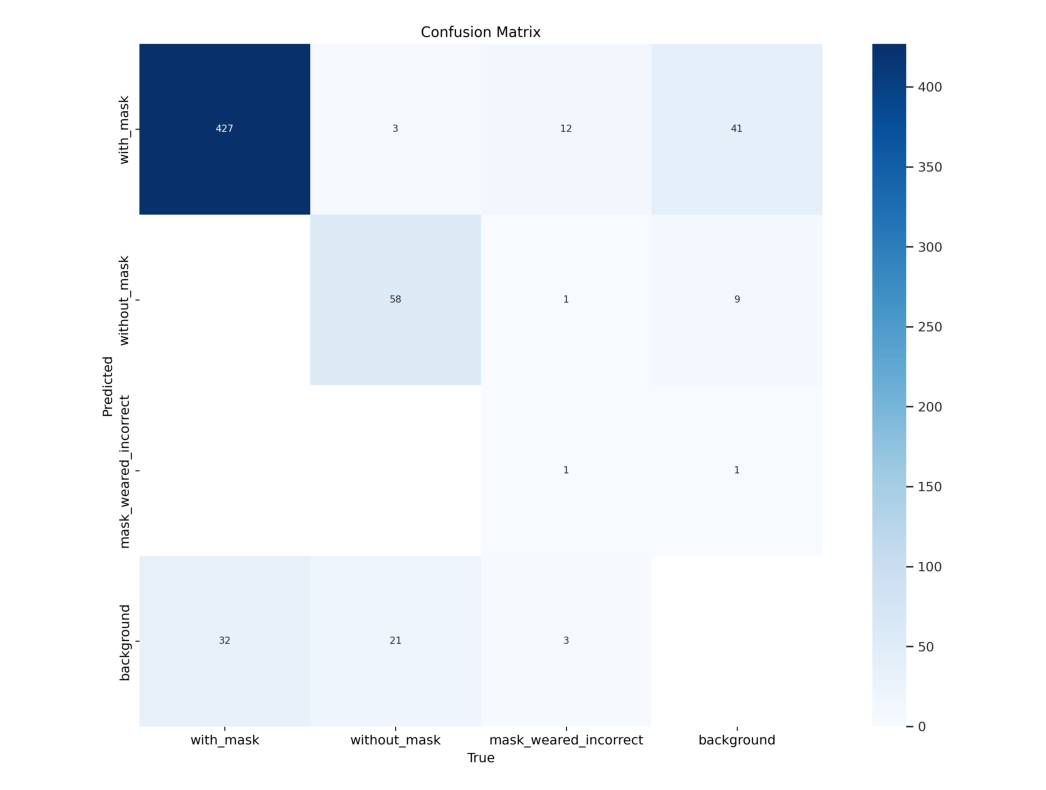

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
confusion_matrix = Image.open("/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/runs/detect/train2/confusion_matrix.png")
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

## Predict

In [ ]:
from ultralytics import YOLO
model = YOLO(model="/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/runs/detect/train4/weights/best.pt")

In [ ]:
import glob, cv2
filenames = glob.glob("/content/drive/MyDrive/Computer_Vision/Face_Mask_Detection/Test"+"/*.png", recursive=False)
test_image1 = cv2.imread(filenames[0])
test_image2 = cv2.imread(filenames[1])

results = model.predict([test_image1, test_image2,test_image3], save=True, line_thickness=1)

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'line_width' instead.

0: 640x640 4 with_masks, 1: 640x640 1 without_mask, 2: 640x640 1 with_mask, 1067.0ms
Speed: 5.0ms preprocess, 355.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train7


Predictions are saved in /content/runs/detect/train3

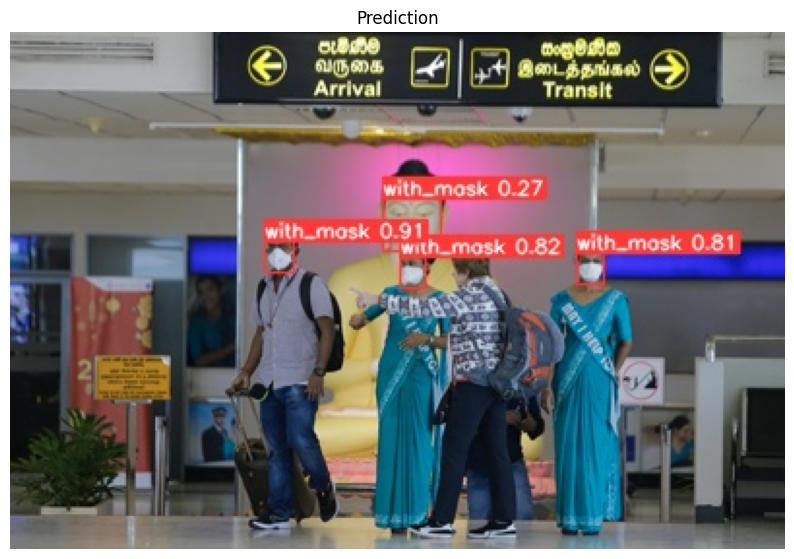

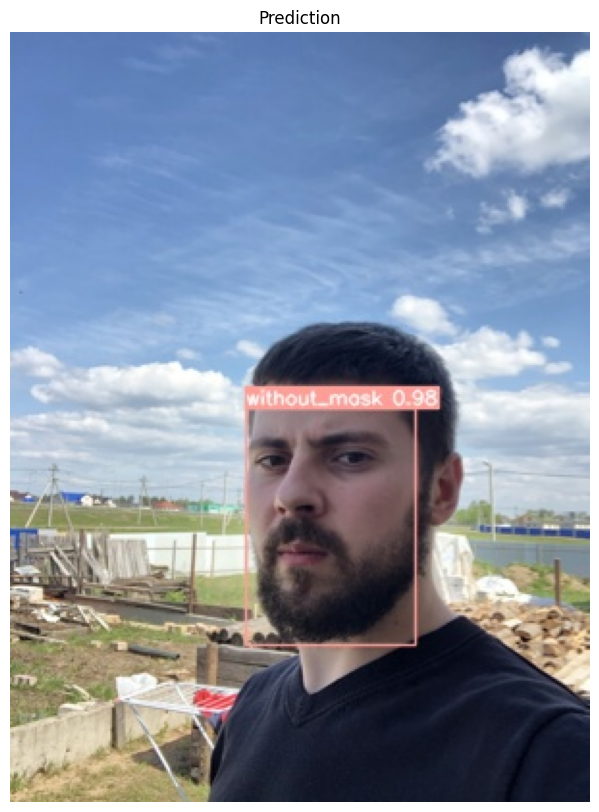

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

predicted_image = Image.open("runs/detect/train/image0.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()

predicted_image = Image.open("runs/detect/train3/image1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()
